# AF/PW Ghana Communities

Notebook to provide filtering and merging of communities and settlements data from GRID3 Settlements Extents and UN OCHA's COD-PP Dataset

Done per-region. A region name/code is immediately applied to the Settlement Extents data to pare down for quicker/easier processing.

In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px

In [6]:
# se_sample_file = "/Users/datascience/Downloads/gh_se_sample.geojson"
# sample_df = gpd.read_file(se_sample_file)
# sample_df.shape
# sample_df.info()
# sample_df["geometry"].iloc[0]

<h2 style="padding:7px; color:gainsboro; background-color:coral;">CONFIG</h2>

In [12]:
# Settlement Extents file
se_file = "/Users/datascience/Data/Ghana_Settlement_Extents_Version_01.01.geojson"

# Populated Places stats file
pp_file = "/Users/datascience/Data/UN OCHA - COD-PP - gha_settlements.xlsx"

In [26]:
# Regions and Select region
regions_pcodes = {
    "Ashanti": "GH02",
    "Eastern": "GH06",
    "Volta": "GH14",
    "Bono": "GH03",
    "Ahafo": "GH01"
}

sel_region = "Bono"

In [21]:
# Population range. NB: applied to UN-adjusted population
pop_min = 1000
pop_max = 20000

In [ ]:
# Export filenames
base_dir = "/Users/datascience/Development/aquaya/py-sandbox/assurance-fund/
export_geojson = 

<h2 style="padding:7px; color:gainsboro; background-color:coral;">DATA LOAD, FILTER, CLEAN</h2>

- Drop rows with NA geometry, population, or region
- Filter to selected region
- Filter to selected population range

In [22]:
se_df = gpd.read_file(se_file, iterator=True, chunksize=1000, index="OBJECTID")
se_df.shape

(374257, 16)

In [23]:
se_df = se_df.dropna(subset=["population", "geometry", "adm1_pcode"])
se_df.shape

(372504, 16)

In [24]:
# Report number of settlements per region
se_df["adm1_name"].value_counts()

adm1_name
Ashanti             53092
Northern            39588
Western North       38623
Western             32902
Eastern             27267
Bono East           25245
Upper West          24598
Upper East          18928
Central             18165
Savannah            17567
Ahafo               17137
Bono                15404
Oti                 13981
Volta               13247
Northern East       12354
Greater Accra        4126
crosses boundary      165
NA                    115
Name: count, dtype: int64

In [34]:
# Filter to single-region dataframe
# NB: We are filtering out any communities here that cross region boundaries or have null name (~165 + 115 re: value counts above). 
reg_se_df = se_df[se_df["adm1_name"] == sel_region].copy()
# del(se_df)
reg_se_df.shape

(15404, 16)

In [31]:
# Sanity check against pcode: All region entries should have name corresponding to pcode
assert (~(reg_se_df["adm1_pcode"] == regions_pcodes[sel_region])).sum() == 0, "Double check region name, pcode, and data"

# Sanity check: Also confirm the number of settlements for selected region above (from `.value_counts()`) is the same as shape here
# EG: Bono should have 15,404 settlements

In [32]:
reg_se_df.head(2)

,OBJECTID,mgrs_code,country,iso,type,population,pop_un_adj,adm0_pcode,adm1_name,adm1_pcode,adm2_name,adm2_pcode,settl_pcode,Shape__Area,Shape__Length,geometry
89298,89299,30NVN9576_01,Ghana,GHA,Built-up Area,9330.778872,8775.381511,GH,Bono,GH03,Dormaa West,GH0306,GH0306000001,0.000279,0.182698,"POLYGON ((-3.04787 7.01249, -3.04763 7.01308, ..."
89299,89300,30NWN1459_01,Ghana,GHA,Small Settlement Area,215.172711,202.364954,GH,Bono,GH03,Dormaa West,GH0306,GH0306000002,0.000012,0.016912,"POLYGON ((-2.87246 6.87104, -2.87173 6.87098, ..."


In [48]:
# Filter settlements to population range -> Create "communities" dataframe
# NB: We can use raw GRID3 population estimate ('population') or UN-adjusted population estimate ('pop_un_adj') here. Preference is for latter.
comms_df = reg_se_df[reg_se_df["pop_un_adj"].between(pop_min, pop_max, inclusive="both")].copy()
# del(reg_se_df)
comms_df.shape

(113, 16)

<h2 style="padding:7px; color:gainsboro; background-color:coral;">EXPLORE</h2>

<Axes: >

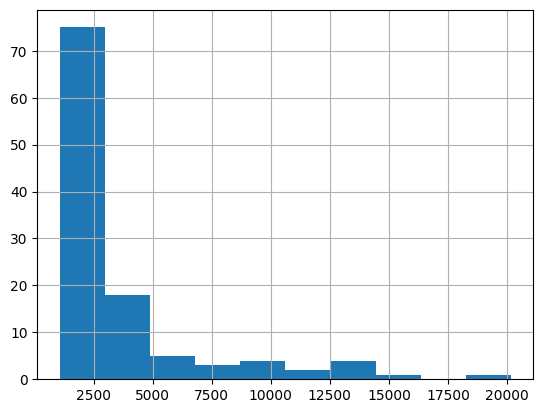

In [49]:
# Basic hist of population count
comms_df["population"].hist()

In [104]:
fmap = comms_df.explore(tiles="CartoDB positron", width=1200)
fmap

<h2 style="padding:7px; color:gainsboro; background-color:coral;">ANNOTATE</h2>

### Add single representative "center" point of each shape

In [61]:
comms_df.head(2)

,OBJECTID,mgrs_code,country,iso,type,population,pop_un_adj,adm0_pcode,adm1_name,adm1_pcode,adm2_name,adm2_pcode,settl_pcode,Shape__Area,Shape__Length,geometry
89298,89299,30NVN9576_01,Ghana,GHA,Built-up Area,9330.778872,8775.381511,GH,Bono,GH03,Dormaa West,GH0306,GH0306000001,0.000279,0.182698,"POLYGON ((-3.04787 7.01249, -3.04763 7.01308, ..."
89313,89314,30NVN9669_01,Ghana,GHA,Small Settlement Area,2252.717726,2118.628874,GH,Bono,GH03,Dormaa West,GH0306,GH0306000016,0.000057,0.043795,"POLYGON ((-3.03423 6.96145, -3.03387 6.96128, ..."


In [111]:
# Ignore warnings - visually analyzing centers shows they are fine. NB: Not always inside settlement shapes. Alternatively can use 'GeoSeries.representative_point
comms_df["approx_center_lat"] = comms_df["geometry"].centroid.y
comms_df["approx_center_lon"] = comms_df["geometry"].centroid.x

/var/folders/_f/bhtpz1nj0216d4sgdjmd9vk40000gn/T/ipykernel_32454/2802848387.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comms_df["approx_center_lat"] = comms_df["geometry"].centroid.y
/var/folders/_f/bhtpz1nj0216d4sgdjmd9vk40000gn/T/ipykernel_32454/2802848387.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comms_df["approx_center_lon"] = comms_df["geometry"].centroid.x


In [114]:
comms_df["geometry"].centroid.explore(m=fmap, color="tomato")

/var/folders/_f/bhtpz1nj0216d4sgdjmd9vk40000gn/T/ipykernel_32454/1376830765.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comms_df["geometry"].centroid.explore(m=fmap, color="tomato")


### Load COD-PP Data, attempt to assign to settlements

Data to add:
- Lat/lon (compare to center)
- NAME, REFNAME
- Pcod
- popPlaceCI nd popPlace1 ?? Not sure what these are - investigate

In [115]:
pp_df = pd.read_excel(pp_file)
pp_df.shape

(11439, 17)

In [116]:
pp_df.head(2)

,LAT,LONG,CNTRY_CODE,NAME,REFNAME,Pcod,popPlaceCI,popPlace1,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo
0,4.750000,-2.066667,GHA,Akrakrom,Ekrakrom,GH15010001,0,Other,Ahanta West Municipal,GH1501,Western,GH15,Ghana,GH,2018-10-26 00:00:00,2021-03-08 00:00:00,NaN
1,4.758333,-2.017778,GHA,Akwidaa Beebianeha,Akwo Babianiba,GH15010002,0,Other,Ahanta West Municipal,GH1501,Western,GH15,Ghana,GH,2018-10-26 00:00:00,2021-03-08 00:00:00,NaN


In [124]:
# Filter to selected region
reg_pp_df = pp_df[pp_df["ADM1_EN"] == sel_region].copy()
reg_pp_df.shape

(241, 17)

In [127]:
reg_pp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 7520 to 8647
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LAT         241 non-null    float64
 1   LONG        241 non-null    float64
 2   CNTRY_CODE  241 non-null    object 
 3   NAME        241 non-null    object 
 4   REFNAME     112 non-null    object 
 5   Pcod        241 non-null    object 
 6   popPlaceCI  241 non-null    int64  
 7   popPlace1   241 non-null    object 
 8   ADM2_EN     241 non-null    object 
 9   ADM2_PCODE  241 non-null    object 
 10  ADM1_EN     241 non-null    object 
 11  ADM1_PCODE  241 non-null    object 
 12  ADM0_EN     241 non-null    object 
 13  ADM0_PCODE  241 non-null    object 
 14  date        241 non-null    object 
 15  validOn     241 non-null    object 
 16  validTo     0 non-null      float64
dtypes: float64(3), int64(1), object(13)
memory usage: 33.9+ KB


<h2 style="padding:7px; color:gainsboro; background-color:coral;">EXPORT</h2>

In [70]:
coms_df.to_file("/Users/datascience/Downloads/GHA Communities - BO,AH - 5-20k.geojson")

In [131]:
pd.DataFrame(coms_df.drop("geometry", axis=1)).to_excel("/Users/datascience/Downloads/GHA Communities - BO,AH - 5-20k - Summary.xlsx", index=False)

## Load COD-PP Data and Merge via geometry membership

In [87]:
reg_pp_df = pp_df[pp_df["ADM1_PCODE"].isin(target_regions_pcodes.values())].copy()
reg_pp_df.shape

(4335, 17)